In [1]:
from typing import Union, Optional, List, NamedTuple

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
from scipy import interpolate
from scipy.integrate import simpson

from hazma.vector_mediator._gev import spectra as spectra_gev
from hazma.vector_mediator._gev import positron as positron_gev
from hazma.vector_mediator import KineticMixingGeV
from hazma.utils import kallen_lambda

from inspect import signature

In [2]:
from hazma.vector_mediator.form_factors.pi_pi_omega import FormFactorPiPiOmega
from hazma import parameters

## Utils

### Colors

In [3]:
qualitative = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#a65628",
    "#f781bf",
    "#999999",
    "#ffff33",
]

colors = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#a65628",
    "#f781bf",
    "#999999",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]

In [4]:
class PlotAnnotation(NamedTuple):
    x: float
    y: float
    label: str
    size: int = 16
    color: str = "k"
    rotation: int = 0

def add_annotation(ax: Axes, annotation: PlotAnnotation):
    ax.text(
        x=annotation.x,
        y=annotation.y,
        s=annotation.label,
        fontdict=dict(size=annotation.size, color=annotation.color),
        rotation=annotation.rotation,
    )

### Plot Parameters

In [5]:
plot_params = dict()
plot_params["l l"] = dict(label=r"$\ell^{+}\ell^{-}$", color=colors[0], ls="-", lw=1)
# plot_params["mu mu"] = dict(label=r"$\mu^{+}\mu^{-}$", color=colors[1], ls="-", lw=1)
plot_params["pi pi"] = dict(label=r"$\pi^{+}\pi^{-}$", color=colors[1], ls="-", lw=1)
plot_params["k0 k0"] = dict(label=r"$K^{0}\bar{K}^{0}$", color=colors[2], ls="-", lw=1)
plot_params["k k"] = dict(label=r"$K^{+}K^{-}$", color=colors[3], ls="-", lw=1)
plot_params["pi0 gamma"] = dict(label=r"$\pi^{0}\gamma$", color=colors[4], ls="-", lw=1)
plot_params["eta gamma"] = dict(label=r"$\eta\gamma$", color=colors[5], ls="-", lw=1)
plot_params["pi0 phi"] = dict(label=r"$\pi^{0}\phi$", color=colors[6], ls="-", lw=1)
plot_params["eta phi"] = dict(label=r"$\eta\phi$", color=colors[7], ls="-", lw=1)
plot_params["eta omega"] = dict(label=r"$\eta\omega$", color=colors[8], ls="-", lw=1)
plot_params["pi0 k0 k0"] = dict(label=r"$\pi^{0}K^{0}\bar{K}^{0}$", color=colors[9], ls="--", lw=1)
plot_params["pi0 k k"] = dict(label=r"$\pi^{0}K^{+}K^{-}$", color=colors[10], ls="--", lw=1)
plot_params["pi k k0"] = dict(label=r"$\pi^{\pm}K^{\mp}K^{0}$", color=colors[11], ls="--", lw=1)
plot_params["pi pi eta"] = dict(label=r"$\pi\pi\eta$", color=colors[12], ls="--", lw=1)
plot_params["pi pi etap"] = dict(label=r"$\pi\pi\eta'$", color=colors[13], ls="--", lw=1)
plot_params["pi pi pi0"] = dict(label=r"$\pi\pi\pi^{0}$", color=colors[14], ls="--", lw=1)
plot_params["pi0 pi0 gamma"] = dict(label=r"$\pi\pi\omega$", color=colors[15], ls="--", lw=1)
plot_params["pi pi omega"] = dict(label=r"$\pi^{0}\pi^{0}\omega$", color=colors[16], ls="--", lw=1)
plot_params["pi0 pi0 omega"] = dict(label=r"$\pi^{0}\pi^{0}\gamma$", color=colors[17], ls="--", lw=1)
plot_params["pi pi pi0 pi0"] = dict(label=r"$\pi\pi\pi^{0}\pi^{0}$", color=colors[18], ls="-.", lw=1)
plot_params["pi pi pi pi"] = dict(label=r"$\pi\pi\pi\pi$", color=colors[19], ls="-.", lw=1)

plot_params["total"] = dict(label=r"$\mathrm{Total}$", color="k")


### Spectrum Utils

In [6]:
class SpectrumLine:
    def __init__(self, xloc, br, mass=0.0) -> None:
        self._xloc = xloc
        self._br = br
        if mass != 0.0:
            raise ValueError("Massless particles not yet implemented.")

    def boost(self, xs, beta: float):
        dndxs = np.zeros_like(xs)
        br = self._br
        if beta >= 0.0 or beta <= 1.0:
            x0 = self._xloc
            xmin = x0 * (1 - beta)
            xmax = x0 * (1 + beta)
            cond = np.logical_and(xmin < xs, xs < xmax)
            dndxs = np.where(cond, br / (2 * beta * x0), 0.0)
        return Spectrum(xs, dndxs)

    def convolve(self, xs, eps):
        x0 = self._xloc
        br = self._br
        xe = x0 * eps
        dndxs = br * np.exp(-0.5 * ((xs - x0) / xe) ** 2) / (np.sqrt(2 * np.pi) * xe)
        return Spectrum(xs, dndxs)


class Spectrum:
    def __init__(
        self,
        x,
        dndx,
        mu: float = 0.0,
        lines: Optional[Union[SpectrumLine, List[SpectrumLine]]] = None,
    ):
        self._x = x
        self._dndx = dndx
        self._mu = mu
        self._spline = self.__make_spline()

        self._lines: List[SpectrumLine]
        if lines is not None:
            if isinstance(lines, list):
                self._lines = lines
            else:
                self._lines = [lines]
        else:
            self._lines = []

    def __make_spline(self):
        spline = interpolate.InterpolatedUnivariateSpline(
            self._x, self._dndx, k=1, ext=1
        )
        return spline

    def __call__(self, x):
        return self._spline(x)

    @property
    def x(self):
        return self._x

    @property
    def dndx(self):
        return self._dndx


    def boost(self, beta: float, trim: bool = True) -> "Spectrum":
        if beta == 0.0:
            return self

        mu1 = self._mu
        x = self._x
        y1 = self._dndx / np.sqrt(x**2 - mu1**2) / (2.0 * beta)
        integrand = interpolate.InterpolatedUnivariateSpline(x, y1, k=1, ext=1)

        g2 = 1.0 / (1.0 - beta**2)
        mu2 = mu1 / np.sqrt(g2)
        x_minus = g2 * x * (1.0 - beta * np.sqrt(1.0 - (mu2 / x) ** 2))
        x_plus = g2 * x * (1.0 + beta * np.sqrt(1.0 - (mu2 / x) ** 2))
        dndx = np.array([integrand.integral(xm, xp) for xm, xp in zip(x_minus, x_plus)])

        if trim:
            idx_min = np.argmin(x_minus > np.min(x))
            x = x[idx_min:]
            dndx = dndx[idx_min:]

        for line in self._lines:
            line_spec = line.boost(x, beta)
            dndx += line_spec.dndx

        return Spectrum(x, dndx)

    def convolve(self, eps):
        eps2 = eps**2
        norm = 1 / np.sqrt(2 * np.pi * eps2)

        def kernel(x, xp):
            return (1.0 / xp) * np.exp(-((1.0 - x / xp) ** 2) / (2.0 * eps2))

        dndx = np.array(
            [simpson(norm * kernel(x, self._x) * self._dndx, self._x) for x in self._x]
        )

        for line in self._lines:
            line_spec = line.convolve(self._x, eps)
            dndx += line_spec.dndx

        return Spectrum(self._x, dndx)

### Spectrum generation

In [7]:
def gev_positron_spectrum(model, es, cme, dm: bool):
    if dm:
        brs = model.annihilation_branching_fractions(cme)
    else:
        pws = model.partial_widths()
        pw = sum(pws.values())
        brs = {key: val / pw for key, val in pws.items()}

    dndes = dict()

    dndes["l l"] = (
          brs["e e"] * positron_gev.dnde_positron_e_e(model, es, cme)
        + brs["mu mu"] * positron_gev.dnde_positron_mu_mu(model, es, cme)
    )
    # dndes["e e"] = brs["e e"] * positron_gev.dnde_positron_e_e(model, es, cme)
    # dndes["mu mu"] = brs["mu mu"] * positron_gev.dnde_positron_mu_mu(model, es, cme)
    dndes["pi pi"] = brs["pi pi"] * positron_gev.dnde_positron_pi_pi(model, es, cme)
    dndes["k0 k0"] = brs["k0 k0"] * positron_gev.dnde_positron_k0_k0(model, es, cme)
    dndes["k k"] = brs["k k"] * positron_gev.dnde_positron_k_k(model, es, cme)
    dndes["pi0 gamma"] = brs["pi0 gamma"] * positron_gev.dnde_positron_pi0_gamma(model, es, cme)
    dndes["eta gamma"] = brs["eta gamma"] * positron_gev.dnde_positron_eta_gamma(model, es, cme)
    dndes["pi0 phi"] = brs["pi0 phi"] * positron_gev.dnde_positron_pi0_phi(model, es, cme)
    dndes["eta phi"] = brs["eta phi"] * positron_gev.dnde_positron_eta_phi(model, es, cme)
    dndes["eta omega"] = brs["eta phi"] * positron_gev.dnde_positron_eta_omega(model, es, cme)
    dndes["pi0 k0 k0"] = brs["pi0 k0 k0"] * positron_gev.dnde_positron_pi0_k0_k0(model, es, cme, nbins=30, npts=1<<16)
    dndes["pi0 k k"] = brs["pi0 k k"] * positron_gev.dnde_positron_pi0_k_k(model, es, cme, nbins=30, npts=1<<16)
    dndes["pi k k0"] = brs["pi k k0"] * positron_gev.dnde_positron_pi_k_k0(model, es, cme, nbins=30, npts=1<<16)
    dndes["pi pi eta"] = brs["pi pi eta"] * positron_gev.dnde_positron_pi_pi_eta(model, es, cme, nbins=30)
    dndes["pi pi etap"] = brs["pi pi etap"] * positron_gev.dnde_positron_pi_pi_etap(model, es, cme, nbins=30)
    dndes["pi pi pi0"] = brs["pi pi pi0"] * positron_gev.dnde_positron_pi_pi_pi0(model, es, cme, nbins=50, npts=1<<16)
    dndes["pi0 pi0 gamma"] = brs["pi0 pi0 gamma"] * positron_gev.dnde_positron_pi0_pi0_gamma(model, es, cme)
    dndes["pi pi omega"] = brs["pi pi omega"] * positron_gev.dnde_positron_pi_pi_omega(model, es, cme, nbins=30)
    dndes["pi0 pi0 omega"] = brs["pi0 pi0 omega"] * positron_gev.dnde_positron_pi0_pi0_omega(model, es, cme, nbins=30)
    dndes["pi pi pi0 pi0"] = brs["pi pi pi0 pi0"] * positron_gev.dnde_positron_pi_pi_pi0_pi0(model, es, cme, nbins=50, npts=1<<17)
    dndes["pi pi pi pi"] = brs["pi pi pi pi"] * positron_gev.dnde_positron_pi_pi_pi_pi(model, es, cme, nbins=30, npts=1<<16)

    lines: dict[str, SpectrumLine] = dict()
    mpi0 = parameters.neutral_pion_mass
    meta = parameters.eta_mass
    lines["pi0 gamma"] = SpectrumLine(xloc=(cme**2 - mpi0**2) / (cme**2),br=brs["pi0 gamma"])
    lines["eta gamma"] = SpectrumLine(xloc=(cme**2 - meta**2) / (cme**2),br=brs["eta gamma"])

    x = 2 * es / cme

    interps = dict()
    total = np.zeros_like(es)
    for key, dnde in dndes.items():
        dndx = cme / 2.0 * dnde
        total += dndx
        ls = []
        if lines.get(key) is not None:
            ls.append(lines[key])
        interps[key] = Spectrum(x, dndx, lines=ls)

    
    interps["total"] = Spectrum(x, total, lines=list(lines.values()))
    return interps

In [8]:

def gev_spectrum(model, es, cme, dm: bool):
    if dm:
        brs = model.annihilation_branching_fractions(cme)
    else:
        pws = model.partial_widths()
        pw = sum(pws.values())
        brs = {key: val / pw for key, val in pws.items()}

    dndes = dict()

    dndes["l l"] = (
          brs["e e"] * spectra_gev.dnde_photon_e_e(model, es, cme)
        + brs["mu mu"] * spectra_gev.dnde_photon_mu_mu(model, es, cme)
    )
    # dndes["e e"] = brs["e e"] * spectra_gev.dnde_photon_e_e(model, es, cme)
    # dndes["mu mu"] = brs["mu mu"] * spectra_gev.dnde_photon_mu_mu(model, es, cme)
    dndes["pi pi"] = brs["pi pi"] * spectra_gev.dnde_photon_pi_pi(model, es, cme)
    dndes["k0 k0"] = brs["k0 k0"] * spectra_gev.dnde_photon_k0_k0(model, es, cme)
    dndes["k k"] = brs["k k"] * spectra_gev.dnde_photon_k_k(model, es, cme)
    dndes["pi0 gamma"] = brs["pi0 gamma"] * spectra_gev.dnde_photon_pi0_gamma(model, es, cme)
    dndes["eta gamma"] = brs["eta gamma"] * spectra_gev.dnde_photon_eta_gamma(model, es, cme)
    dndes["pi0 phi"] = brs["pi0 phi"] * spectra_gev.dnde_photon_pi0_phi(model, es, cme)
    dndes["eta phi"] = brs["eta phi"] * spectra_gev.dnde_photon_eta_phi(model, es, cme)
    dndes["eta omega"] = brs["eta phi"] * spectra_gev.dnde_photon_eta_omega(model, es, cme)
    dndes["pi0 k0 k0"] = brs["pi0 k0 k0"] * spectra_gev.dnde_photon_pi0_k0_k0(model, es, cme, nbins=30, npts=1<<16)
    dndes["pi0 k k"] = brs["pi0 k k"] * spectra_gev.dnde_photon_pi0_k_k(model, es, cme, nbins=30, npts=1<<16)
    dndes["pi k k0"] = brs["pi k k0"] * spectra_gev.dnde_photon_pi_k_k0(model, es, cme, nbins=30, npts=1<<16)
    dndes["pi pi eta"] = brs["pi pi eta"] * spectra_gev.dnde_photon_pi_pi_eta(model, es, cme, nbins=30)
    dndes["pi pi etap"] = brs["pi pi etap"] * spectra_gev.dnde_photon_pi_pi_etap(model, es, cme, nbins=30)
    dndes["pi pi pi0"] = brs["pi pi pi0"] * spectra_gev.dnde_photon_pi_pi_pi0(model, es, cme, nbins=50, npts=1<<16)
    dndes["pi0 pi0 gamma"] = brs["pi0 pi0 gamma"] * spectra_gev.dnde_photon_pi0_pi0_gamma(model, es, cme)
    dndes["pi pi omega"] = brs["pi pi omega"] * spectra_gev.dnde_photon_pi_pi_omega(model, es, cme, nbins=30)
    dndes["pi0 pi0 omega"] = brs["pi0 pi0 omega"] * spectra_gev.dnde_photon_pi0_pi0_omega(model, es, cme, nbins=30)
    dndes["pi pi pi0 pi0"] = brs["pi pi pi0 pi0"] * spectra_gev.dnde_photon_pi_pi_pi0_pi0(model, es, cme, nbins=50, npts=1<<17)
    dndes["pi pi pi pi"] = brs["pi pi pi pi"] * spectra_gev.dnde_photon_pi_pi_pi_pi(model, es, cme, nbins=30, npts=1<<16)

    lines: dict[str, SpectrumLine] = dict()
    mpi0 = parameters.neutral_pion_mass
    meta = parameters.eta_mass
    lines["pi0 gamma"] = SpectrumLine(xloc=(cme**2 - mpi0**2) / (cme**2),br=brs["pi0 gamma"])
    lines["eta gamma"] = SpectrumLine(xloc=(cme**2 - meta**2) / (cme**2),br=brs["eta gamma"])

    x = 2 * es / cme

    interps = dict()
    total = np.zeros_like(es)
    for key, dnde in dndes.items():
        dndx = cme / 2.0 * dnde
        total += dndx
        ls = []
        if lines.get(key) is not None:
            ls.append(lines[key])
        interps[key] = Spectrum(x, dndx, lines=ls)

    
    interps["total"] = Spectrum(x, total, lines=list(lines.values()))
    return interps

## MV = 800 MeV

In [29]:
model = KineticMixingGeV(1e5, 8e2, 1.0, 1e-3)
cme = model.mv
es = np.geomspace(cme * 1e-4, cme, 500)
dndx_photon_08gev: dict[str, Spectrum] = gev_spectrum(model, es, cme, dm=False)

In [30]:
def plot_800gev(ax, dndx_photon_08gev, ymin=1e-4, ymax=1e-1, xmin=1e-2, xmax=1.5):
    citer = iter(colors)
    for key, dndx in dndx_photon_08gev.items():
        dndx2 = dndx.convolve(0.05)
        x = dndx2.x
        mask = x > xmin
        x = x[mask]
        dndx_ = dndx2.dndx[mask]
        if np.max(x**2 * dndx_) > ymin:
            label = plot_params[key]["label"]
            if key == "total":
                params = dict(color="k", ls="-", lw="1.5", label=label, alpha=0.7)
            else:
                params = dict(color=next(citer), ls="-", lw="1", label=label)
            ax.plot(x, x**2 * dndx_, **params)

    tex = [
        r"\begin{align*}",
        r"\sqrt{s} &= 800 \ \mathrm{MeV}\\",
        r"g_{Vf} &= \epsilon Q_{f}\\",
        r"\end{align*}",
    ]
    ax.text(1.2e-2, 5e-2, " ".join(tex), fontdict=dict(size=16))

    text_labels = [
        PlotAnnotation(x=1.5e-2, y=1.7e-4, label=r"$\ell^{+}\ell^{-}$", size=12, color=colors[0]),
        PlotAnnotation(x=2e-1, y=1.2e-2, label=r"$\pi^{+}\pi^{-}\pi^{0}$", size=12, color=colors[4]),
        PlotAnnotation(x=5e-1, y=9e-3, label=r"$\pi^{0}\gamma$", size=12, color=colors[2]),
        PlotAnnotation(x=2e-2, y=3.8e-4, label=r"$\pi^{+}\pi^{-}$", size=12, color=colors[1]),
        PlotAnnotation(x=3e-1, y=2.5e-4, label=r"$\eta\gamma$", size=12, color=colors[3]),
    ]

    for tl in text_labels:
        if ymin < tl.y < ymax:
            add_annotation(ax, tl)


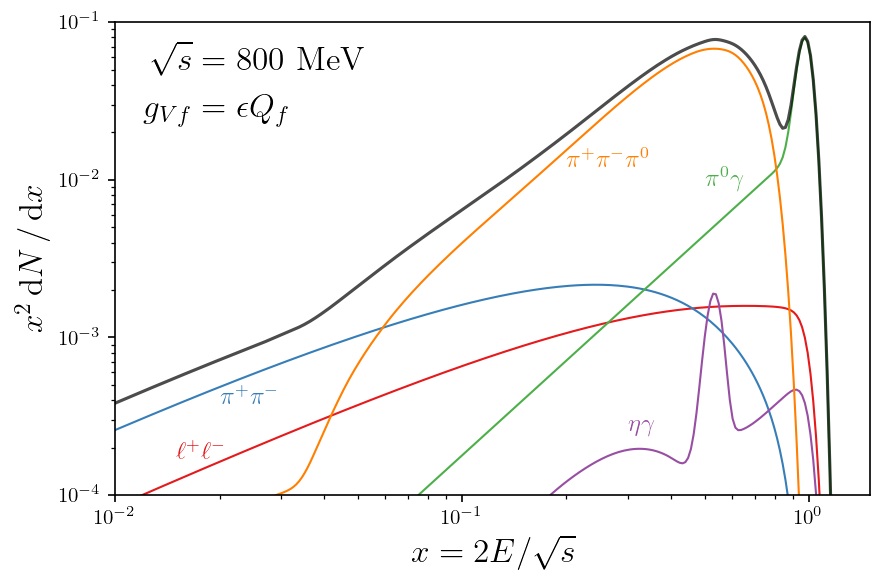

In [31]:
plt.figure(dpi=150, figsize=(6,4))

xmin, xmax = 1e-2, 1.5
ymin, ymax = 1e-4, 1e-1
citer = iter(colors)

for key, dndx in dndx_photon_08gev.items():
    dndx2 = dndx.convolve(0.05)
    x = dndx2.x
    mask = x > xmin
    x = x[mask]
    dndx_ = dndx2.dndx[mask]
    if np.max(x**2 * dndx_) > ymin:
        label = plot_params[key]["label"]
        if key == "total":
            params = dict(color="k", ls="-", lw="1.5", label=label, alpha=0.7)
        else:
            params = dict(color=next(citer), ls="-", lw="1", label=label)
        plt.plot(x, x**2 * dndx_, **params)


tex = [
    r"\begin{align*}",
    r"\sqrt{s} &= 800 \ \mathrm{MeV}\\",
    r"g_{Vf} &= \epsilon Q_{f}\\",
    r"\end{align*}"
]
plt.text(1.2e-2, 5e-2, " ".join(tex), fontdict=dict(size=16))
plt.text(1.5e-2, 1.7e-4, r"$\ell^{+}\ell^{-}$", fontdict=dict(size=12,color=colors[0]))
plt.text(2e-1, 1.2e-2, r"$\pi^{+}\pi^{-}\pi^{0}$", fontdict=dict(size=12,color=colors[4]))
plt.text(5e-1, 9e-3, r"$\pi^{0}\gamma$", fontdict=dict(size=12,color=colors[2]))
plt.text(2e-2, 3.8e-4, r"$\pi^{+}\pi^{-}$", fontdict=dict(size=12,color=colors[1]))
plt.text(3e-1, 2.5e-4, r"$\eta\gamma$", fontdict=dict(size=12,color=colors[3]))


plt.yscale("log")
plt.xscale("log")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.ylabel(r"$x^{2}\dd{N}/\dd{x}$", fontdict=dict(size=16))
plt.xlabel(r"$x = 2E/\sqrt{s}$", fontdict=dict(size=16))
#plt.legend(loc=0, bbox_to_anchor=(1.02, 0.9))
# plt.title(r"$M_{V} = 800 \ \mathrm{MeV}$", fontdict=dict(size=16))
plt.tight_layout()

## MV = 1 GeV

In [18]:
model = KineticMixingGeV(1e5, 1e3, 1.0, 1e-3)
cme = model.mv
es = np.geomspace(cme * 1e-4, cme, 800)
dndx_photon_1gev: dict[str, Spectrum] = gev_spectrum(model, es, cme, dm=False)

/home/logan/github/Hazma/hazma/spectra/_photon/__init__.py:169: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return _pion.dnde_photon_charged_pion(photon_energy, pion_energy)


In [19]:
def plot_1gev(ax, dndx_photon_1gev, xmin=1e-2, xmax=1.5, ymin=1e-6, ymax=2e-1):
    energy_res = 0.05

    dndx_photon = dndx_photon_1gev.copy()
    dndx_photon["k k"] = Spectrum(
        x=dndx_photon_1gev["k k"].x,
        dndx=dndx_photon_1gev["k k"].dndx + dndx_photon_1gev["k0 k0"].dndx,
    )
    del dndx_photon["k0 k0"]
    pparams = plot_params.copy()
    pparams["k k"]["label"] = r"$KK$"

    citer = iter(colors)
    for key, dndx in dndx_photon.items():
        dndx2 = dndx.convolve(energy_res)
        x = dndx2.x
        mask = x > xmin
        x = x[mask]
        dndx_ = dndx2.dndx[mask]
        if np.max(x**2 * dndx_) > ymin:
            params = pparams[key].copy()
            if not key == "total":
                params["color"] = next(citer)
            params["ls"] = "-"
            ax.plot(x, x**2 * dndx_, **params)

    tex = [
        r"\begin{align*}",
        r"\sqrt{s} &= 1 \ \mathrm{GeV}\\",
        r"\end{align*}",
    ]
    ax.text(1.2e-2, 6e-2, " ".join(tex), fontdict=dict(size=16))

    text_labels = [
        PlotAnnotation(x=1.2e-2, y=5e-6,   label=r"$KK$", size=12, color=colors[2]),
        PlotAnnotation(x=1e-1,   y=9e-6,   label=r"$2(\pi^{+}\pi^{-})$", size=12, color=colors[8]),
        PlotAnnotation(x=3e-1,   y=1.5e-5, label=r"$\pi^{+}\pi^{-}\eta$", size=12, color=colors[5]),
        PlotAnnotation(x=2.5e-1, y=7e-3,   label=r"$\pi^{+}\pi^{-}\pi^{0}\pi^{0}$", size=12, color=colors[7]),
        PlotAnnotation(x=1.2e-2, y=1.6e-4, label=r"$\ell^{+}\ell^{-}$", size=12, color=colors[0]),
        PlotAnnotation(x=1.1e-2, y=5.5e-5, label=r"$\pi^{+}\pi^{-}$", size=12, color=colors[1], rotation=10), 
        PlotAnnotation(x=1.1e-2, y=2.5e-5, label=r"$\pi^{+}\pi^{-}\pi^{0}$", size=12, color=colors[6], rotation=10),
        PlotAnnotation(x=1.1e-1, y=2.5e-4, label=r"$\eta\gamma$", size=12, color=colors[4]),
        PlotAnnotation(x=2e-1,   y=2.5e-4, label=r"$\pi^{0}\gamma$", size=12, color=colors[3]),
    ]

    for tl in text_labels:
        if ymin < tl.y < ymax:
            add_annotation(ax, tl)


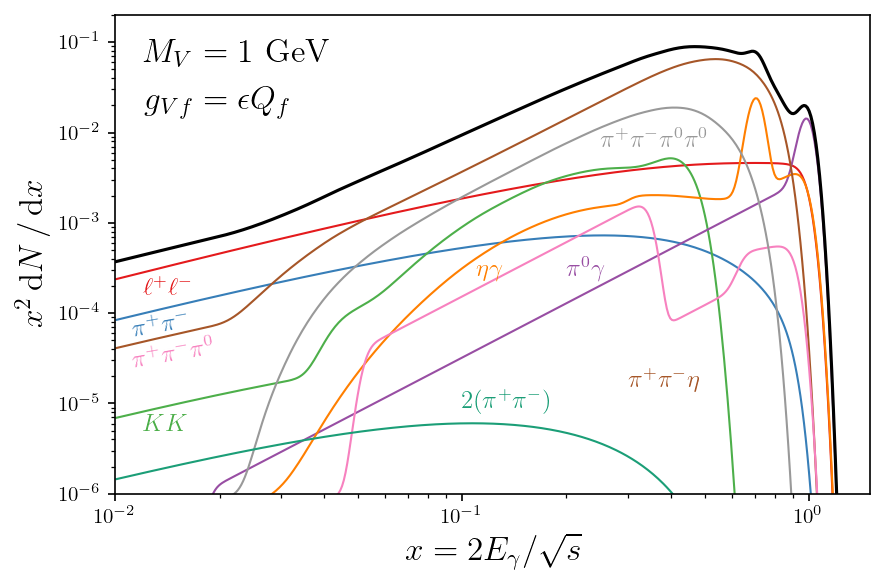

In [25]:
plt.figure(dpi=150, figsize=(6,4))

energy_res = 0.05
xmin, xmax = 1e-2, 1.5
ymin, ymax = 1e-6, 2e-1

dndx_photon = dndx_photon_1gev.copy()
dndx_photon["k k"] = Spectrum(
    x=dndx_photon_1gev["k k"].x,
    dndx=dndx_photon_1gev["k k"].dndx + dndx_photon_1gev["k0 k0"].dndx,
)
del dndx_photon["k0 k0"]
pparams = plot_params.copy()
pparams["k k"]["label"] = r"$KK$"

citer = iter(colors)
for key, dndx in dndx_photon.items():
    dndx2 = dndx.convolve(energy_res)
    x = dndx2.x
    mask = x > xmin
    x = x[mask]
    dndx_ = dndx2.dndx[mask]
    if np.max(x**2 * dndx_) > ymin:
        params = pparams[key].copy()
        if not key == "total":
            params["color"] = next(citer)
        params["ls"] = "-"
        plt.plot(x, x**2 * dndx_, **params)

# citer = iter(colors)
# for key, dndx in dndx_photon.items():
#     dndx2 = dndx.convolve(0.01)
#     x = dndx2.x
#     mask = x > xmin
#     x = x[mask]
#     dndx_ = dndx2.dndx[mask]
#     if np.max(x**2 * dndx_) > ymin:
#         params = pparams[key].copy()
#         if not key == "total":
#             params["color"] = next(citer)
#         params["alpha"] = 0.3
#         params["ls"] = "-"
#         plt.plot(x, x**2 * dndx_, **params)

# citer = iter(colors)
# for key, dndx in dndx_photon.items():
#     dndx2 = dndx.convolve(0.1)
#     x = dndx2.x
#     mask = x > xmin
#     x = x[mask]
#     dndx_ = dndx2.dndx[mask]
#     if np.max(x**2 * dndx_) > ymin:
#         params = pparams[key].copy()
#         if not key == "total":
#             params["color"] = next(citer)
#         params["alpha"] = 0.3
#         params["ls"] = "-."
#         plt.plot(x, x**2 * dndx_, **params)


plt.yscale("log")
plt.xscale("log")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.ylabel(r"$x^{2}\dd{N}/\dd{x}$", fontdict=dict(size=16))
plt.xlabel(r"$x = 2E_{\gamma}/\sqrt{s}$", fontdict=dict(size=16))
# plt.legend(loc=0, ncol=1, bbox_to_anchor=(1.02, 0.9))
# plt.title(r"$M_{V} = 1 \ \mathrm{GeV}$", fontdict=dict(size=16))
plt.text(1.2e-2, 5e-6, r"$KK$", fontdict=dict(size=12,color=colors[2]))
plt.text(1e-1, 9e-6, r"$2(\pi^{+}\pi^{-})$", fontdict=dict(size=12,color=colors[8]))
plt.text(3e-1, 1.5e-5, r"$\pi^{+}\pi^{-}\eta$", fontdict=dict(size=12,color=colors[5]))
plt.text(2.5e-1, 7e-3, r"$\pi^{+}\pi^{-}\pi^{0}\pi^{0}$", fontdict=dict(size=12,color=colors[7]))

plt.text(1.2e-2, 1.6e-4, r"$\ell^{+}\ell^{-}$", fontdict=dict(size=12,color=colors[0]))
plt.text(1.1e-2, 5.5e-5, r"$\pi^{+}\pi^{-}$", fontdict=dict(size=12,color=colors[1]), rotation=10)
plt.text(1.1e-2, 2.5e-5, r"$\pi^{+}\pi^{-}\pi^{0}$", fontdict=dict(size=12,color=colors[6]),rotation=10)

plt.text(1.1e-1, 2.5e-4, r"$\eta\gamma$", fontdict=dict(size=12,color=colors[4]))
# plt.annotate("", (7e-1, 1.3e-2), (1e0, 4e-2), arrowprops=dict(arrowstyle="->", color=colors[4]))

plt.text(2e-1, 2.5e-4, r"$\pi^{0}\gamma$", fontdict=dict(size=12,color=colors[3]))
# plt.annotate("", (9.8e-1, 7e-3), (1.5e-0, 2.8e-2), arrowprops=dict(arrowstyle="->", color=colors[3]))

tex = [
    r"\begin{align*}",
    r"M_{V} &= 1 \ \mathrm{GeV}\\",
    r"g_{Vf} &= \epsilon Q_{f}\\",
    r"\end{align*}"
]

plt.text(1.2e-2, 6e-2, " ".join(tex), fontdict=dict(size=16))
# plt.text(1.2e-2, 6e-2, r"$M_{V} = 1 \ \mathrm{GeV}$", fontdict=dict(size=16))
#plt.text(1.2e-2, 3e-2, r"$g_{Vu} = \epsilon Q_u$", fontdict=dict(size=16))

# plt.grid(alpha=0.3, which="major")
plt.tight_layout()
plt.savefig("dndx_photon_1gev.pdf")

## MV = 5 GeV

In [21]:
model = KineticMixingGeV(1e5, 1.2e3, 1.0, 1e-3)
cme = model.mv
es = np.geomspace(cme * 1e-4, cme, 500)
dndx_photon_5gev: dict[str, Spectrum] = gev_spectrum(model, es, cme, dm=False)

In [22]:
def plot_12gev(ax, dndx_photon_5gev, xmin=1e-2, xmax=1.5, ymin=1e-5, ymax=2e-1):
    dndx_photon = dndx_photon_5gev.copy()
    dndx_photon["k k"] = Spectrum(
        x=dndx_photon_5gev["k k"].x,
        dndx=dndx_photon_5gev["k k"].dndx + dndx_photon_5gev["k0 k0"].dndx,
    )

    del dndx_photon["k0 k0"]
    pparams = plot_params.copy()
    pparams["k k"]["label"] = r"$KK$"

    dndx_photon["pi pi pi pi"] = Spectrum(
        x=dndx_photon_5gev["pi pi pi pi"].x,
        dndx=dndx_photon_5gev["pi pi pi pi"].dndx + dndx_photon_5gev["pi pi pi0 pi0"].dndx,
    )

    del dndx_photon["pi pi pi0 pi0"]
    pparams = plot_params.copy()
    pparams["pi pi pi pi"]["label"] = r"$4\pi$"

    citer = iter(colors)
    for key, dndx in dndx_photon.items():
        dndx2 = dndx.convolve(0.05)
        x = dndx2.x
        mask = x > xmin
        x = x[mask]
        dndx_ = dndx2.dndx[mask]
        if np.max(x**2 * dndx_) > ymin:
            label = plot_params[key]["label"]
            if key == "total":
                params = dict(color="k", ls="-", lw="1.5", label=label, alpha=0.7)
            else:
                params = dict(color=next(citer), ls="-", lw="1", label=label)
            ax.plot(x, x**2 * dndx_, **params)

    tex = [
        r"\begin{align*}",
        r"\sqrt{s} &= 1.2 \ \mathrm{GeV}\\",
        r"\end{align*}"
    ]

    ax.text(1.2e-2, 6e-2, " ".join(tex), fontdict=dict(size=16))

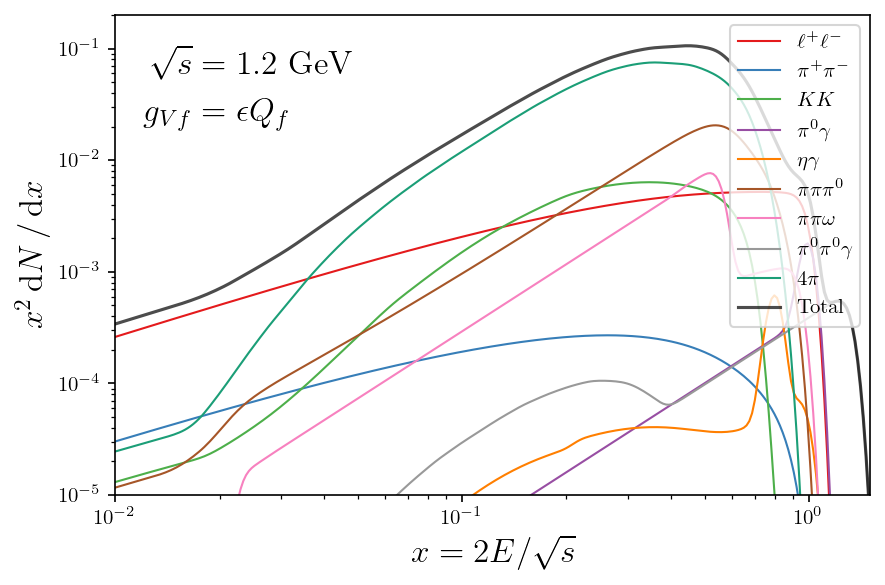

In [23]:
plt.figure(dpi=150, figsize=(6,4))

xmin, xmax = 1e-2, 1.5
ymin, ymax = 1e-5, 2e-1

dndx_photon = dndx_photon_5gev.copy()
dndx_photon["k k"] = Spectrum(
    x=dndx_photon_5gev["k k"].x,
    dndx=dndx_photon_5gev["k k"].dndx + dndx_photon_5gev["k0 k0"].dndx,
)

del dndx_photon["k0 k0"]
pparams = plot_params.copy()
pparams["k k"]["label"] = r"$KK$"

dndx_photon["pi pi pi pi"] = Spectrum(
    x=dndx_photon_5gev["pi pi pi pi"].x,
    dndx=dndx_photon_5gev["pi pi pi pi"].dndx + dndx_photon_5gev["pi pi pi0 pi0"].dndx,
)

del dndx_photon["pi pi pi0 pi0"]
pparams = plot_params.copy()
pparams["pi pi pi pi"]["label"] = r"$4\pi$"

citer = iter(colors)
for key, dndx in dndx_photon.items():
    dndx2 = dndx.convolve(0.05)
    x = dndx2.x
    mask = x > xmin
    x = x[mask]
    dndx_ = dndx2.dndx[mask]
    if np.max(x**2 * dndx_) > ymin:
        label = plot_params[key]["label"]
        if key == "total":
            params = dict(color="k", ls="-", lw="1.5", label=label, alpha=0.7)
        else:
            params = dict(color=next(citer), ls="-", lw="1", label=label)
        plt.plot(x, x**2 * dndx_, **params)

tex = [
    r"\begin{align*}",
    r"\sqrt{s} &= 1.2 \ \mathrm{GeV}\\",
    r"g_{Vf} &= \epsilon Q_{f}\\",
    r"\end{align*}"
]

plt.text(1.2e-2, 6e-2, " ".join(tex), fontdict=dict(size=16))

plt.yscale("log")
plt.xscale("log")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.ylabel(r"$x^{2}\dd{N}/\dd{x}$", fontdict=dict(size=16))
plt.xlabel(r"$x = 2E/\sqrt{s}$", fontdict=dict(size=16))
plt.legend(loc=1, ncol=1)
# plt.title(r"$M_{V} = 5 \ \mathrm{GeV}$", fontdict=dict(size=16))
plt.tight_layout()

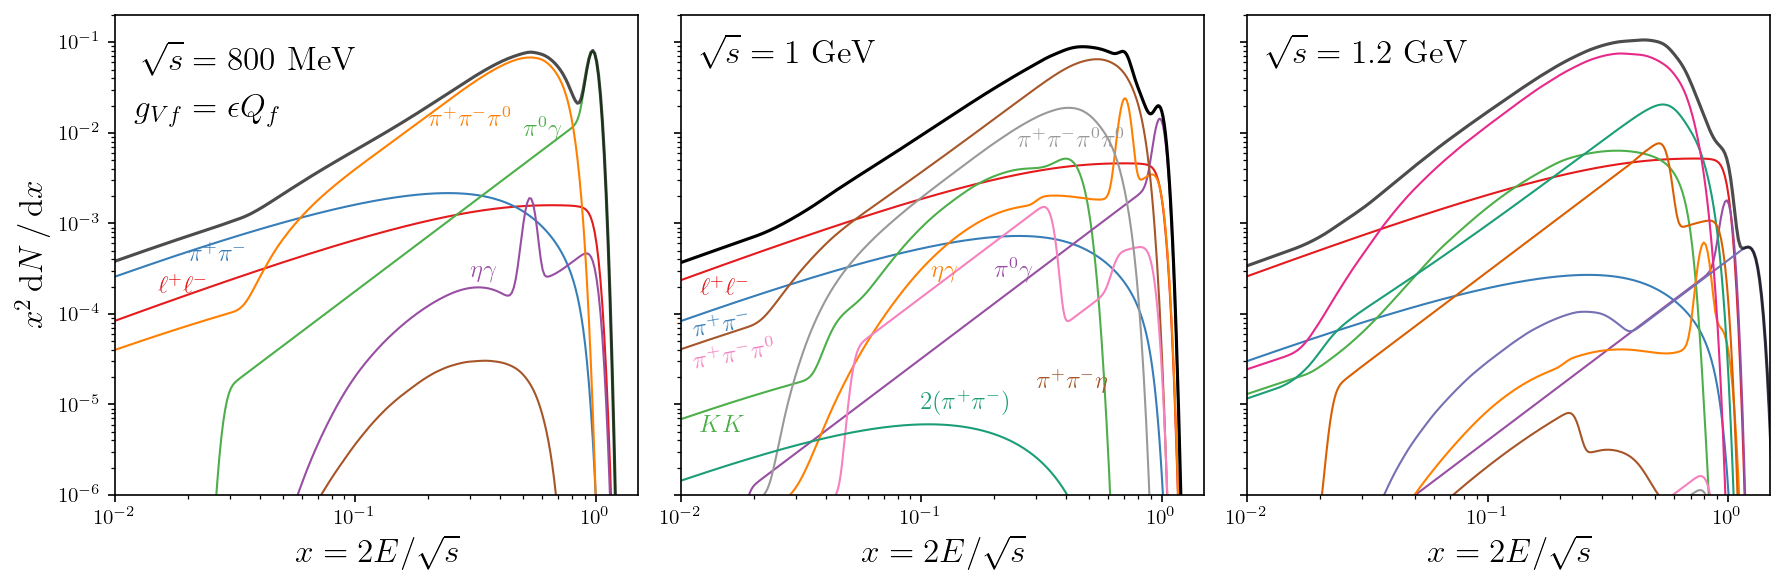

In [32]:
ymin, ymax = 1e-6, 2e-1
xmin, xmax = 1e-2, 1.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4), dpi=150)
plot_800gev(ax1, dndx_photon_08gev, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
plot_1gev(ax2, dndx_photon_1gev, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
plot_12gev(ax3, dndx_photon_5gev, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.yscale("log")
plt.xscale("log")

ax1.set_ylabel(r"$x^{2}\dd{N}/\dd{x}$", fontdict=dict(size=16))
ax1.set_xlabel(r"$x = 2E/\sqrt{s}$", fontdict=dict(size=16))
ax2.set_xlabel(r"$x = 2E/\sqrt{s}$", fontdict=dict(size=16))
ax3.set_xlabel(r"$x = 2E/\sqrt{s}$", fontdict=dict(size=16))

plt.tight_layout()

In [33]:
cme = model.mv
es = np.geomspace(cme * 1e-6, cme, 500)

pws = model.partial_widths()
pw = sum(pws.values())
brs = {key: val / pw for key, val in pws.items()}

dnde_e_e = brs["e e"] * spectra_gev.dnde_photon_e_e(model, es, cme)
dnde_mu_mu = brs["mu mu"] * spectra_gev.dnde_photon_mu_mu(model, es, cme)

dnde_pi_pi = brs["pi pi"] * spectra_gev.dnde_photon_pi_pi(model, es, cme)
dnde_k0_k0 = brs["k0 k0"] * spectra_gev.dnde_photon_k0_k0(model, es, cme)
dnde_k_k = brs["k k"] * spectra_gev.dnde_photon_k_k(model, es, cme)

dnde_pi0_gamma = brs["pi0 gamma"] * spectra_gev.dnde_photon_pi0_gamma(model, es, cme)
dnde_eta_gamma = brs["eta gamma"] * spectra_gev.dnde_photon_eta_gamma(model, es, cme)
dnde_pi0_phi = brs["pi0 phi"] * spectra_gev.dnde_photon_pi0_phi(model, es, cme)
dnde_eta_phi = brs["eta phi"] * spectra_gev.dnde_photon_eta_phi(model, es, cme)
dnde_eta_omega = brs["eta phi"] * spectra_gev.dnde_photon_eta_omega(model, es, cme)

dnde_pi0_k0_k0 = brs["pi0 k0 k0"] * spectra_gev.dnde_photon_pi0_k0_k0(model, es, cme, nbins=30, npts=1<<16)
dnde_pi0_k_k = brs["pi0 k k"] * spectra_gev.dnde_photon_pi0_k_k(model, es, cme, nbins=30, npts=1<<16)
dnde_pi_k_k0 = brs["pi k k0"] * spectra_gev.dnde_photon_pi_k_k0(model, es, cme, nbins=30, npts=1<<16)
dnde_pi_pi_eta = brs["pi pi eta"] * spectra_gev.dnde_photon_pi_pi_eta(model, es, cme, nbins=30)
dnde_pi_pi_etap = brs["pi pi etap"] * spectra_gev.dnde_photon_pi_pi_etap(model, es, cme, nbins=30)
dnde_pi_pi_pi0 = brs["pi pi pi0"] * spectra_gev.dnde_photon_pi_pi_pi0(model, es, cme, nbins=30, npts=1<<16)
dnde_pi0_pi0_gamma = brs["pi0 pi0 gamma"] * spectra_gev.dnde_photon_pi0_pi0_gamma(model, es, cme)

dnde_pi_pi_omega = brs["pi pi omega"] * spectra_gev.dnde_photon_pi_pi_omega(model, es, cme, nbins=30)
dnde_pi0_pi0_omega = brs["pi0 pi0 omega"] * spectra_gev.dnde_photon_pi0_pi0_omega(model, es, cme, nbins=30)

dnde_pi_pi_pi0_pi0 = brs["pi pi pi0 pi0"] * spectra_gev.dnde_photon_pi_pi_pi0_pi0(model, es, cme, nbins=50, npts=1<<17)
dnde_pi_pi_pi_pi = brs["pi pi pi pi"] * spectra_gev.dnde_photon_pi_pi_pi_pi(model, es, cme, nbins=30, npts=1<<16)

In [34]:
class PlotAttrs:
    def __init__(self):
        self.colors = [
            "#e41a1c",
            "#377eb8",
            "#4daf4a",
            "#984ea3",
            "#ff7f00",
            "#a65628",
            "#f781bf",
            "#999999",
            "#1b9e77",
            "#d95f02",
            "#7570b3",
            "#e7298a",
            "#66a61e",
            "#e6ab02",
            "#a6761d",
            "#666666",
            "#66c2a5",
            "#fc8d62",
            "#8da0cb",
            "#e78ac3",
            "#a6d854",
            "#ffd92f",
            "#e5c494",
            "#b3b3b3",
        ]

        self.idx = 0

    def get_attrs(self):
        n = len(self.colors)
        color = self.colors[self.idx % n]
        if self.idx < n:
            ls = "-"
        elif self.idx < 2 * n:
            ls = "--"
        elif self.idx < 3 * n:
            ls = "-."
        else:
            self.idx = -1
            ls = "-"
        self.idx += 1
            

        return {"color": color, "linestyle": ls}


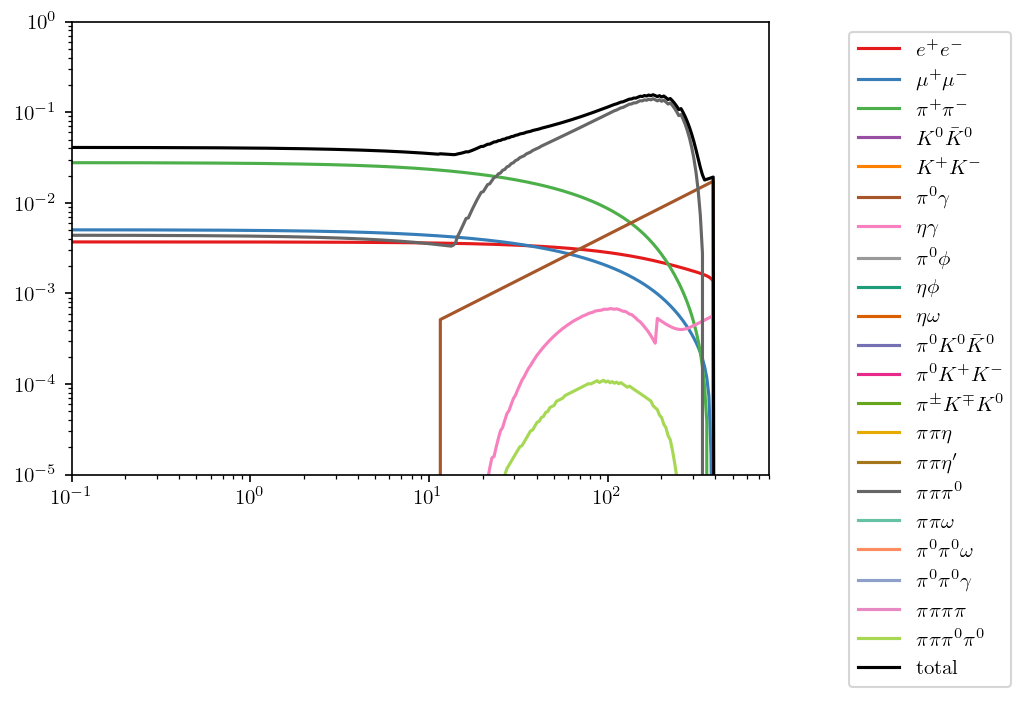

In [35]:
plt.figure(dpi=150)


dnde = (
    + dnde_e_e
    + dnde_mu_mu
    + dnde_pi_pi
    + dnde_k0_k0
    + dnde_k_k
    + dnde_pi0_gamma
    + dnde_eta_gamma

    + dnde_pi0_phi
    + dnde_eta_phi
    + dnde_eta_omega

    + dnde_pi0_k0_k0
    + dnde_pi0_k_k
    + dnde_pi_k_k0
    + dnde_pi_pi_eta
    + dnde_pi_pi_etap
    + dnde_pi_pi_etap
    + dnde_pi_pi_pi0
    + dnde_pi_pi_omega
    + dnde_pi0_pi0_omega
    + dnde_pi0_pi0_gamma

    + dnde_pi_pi_pi_pi
    + dnde_pi_pi_pi0_pi0
)

pattrs = PlotAttrs()

plt.plot(es, es * dnde_e_e, label=r"$e^{+}e^{-}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_mu_mu, label=r"$\mu^{+}\mu^{-}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_pi, label=r"$\pi^{+}\pi^{-}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_k0_k0, label=r"$K^{0}\bar{K}^{0}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_k_k, label=r"$K^{+}K^{-}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi0_gamma, label=r"$\pi^{0}\gamma$", **pattrs.get_attrs())
plt.plot(es, es * dnde_eta_gamma, label=r"$\eta\gamma$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi0_phi, label=r"$\pi^{0}\phi$", **pattrs.get_attrs())
plt.plot(es, es * dnde_eta_phi, label=r"$\eta\phi$", **pattrs.get_attrs())
plt.plot(es, es * dnde_eta_omega, label=r"$\eta\omega$", **pattrs.get_attrs())


plt.plot(es, es * dnde_pi0_k0_k0, label=r"$\pi^{0}K^{0}\bar{K}^{0}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi0_k_k, label=r"$\pi^{0}K^{+}K^{-}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_k_k0, label=r"$\pi^{\pm}K^{\mp}K^{0}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_pi_eta, label=r"$\pi\pi\eta$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_pi_etap, label=r"$\pi\pi\eta'$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_pi_pi0, label=r"$\pi\pi\pi^{0}$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_pi_omega, label=r"$\pi\pi\omega$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi0_pi0_omega, label=r"$\pi^{0}\pi^{0}\omega$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi0_pi0_gamma, label=r"$\pi^{0}\pi^{0}\gamma$", **pattrs.get_attrs())

plt.plot(es, es * dnde_pi_pi_pi_pi, label=r"$\pi\pi\pi\pi$", **pattrs.get_attrs())
plt.plot(es, es * dnde_pi_pi_pi0_pi0, label=r"$\pi\pi\pi^{0}\pi^{0}$", **pattrs.get_attrs())

plt.plot(es, es * dnde, label="total", c="k")

plt.ylim(1e-5, 1e0)
plt.xlim(1e-1, np.max(es))

plt.yscale("log")
plt.xscale("log")
plt.legend(loc=0, bbox_to_anchor=(1.1,1.0))
